# MNIST

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Data Set

### MNIST

The MNIST data set is a large database of handwritten digits, often used as toy model to validate machine learning and deep learning algorithms in image recognition and classification.

### Loading the Data Set

Let's start by loading the MNIST dataset. Since we want to use the data (both images and associated labels) with PyTorch we have to load the dataset into `torch.tensor`s. Additionally we want our data to be normalised in order to avoid large variations in the data; we can compose the two transformation and apply them directly when loading the dataset.

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Array to PyTorch tensor
        transforms.Normalize((0.5,), (0.5,)), # Normalisation (mean and std)
    ]
)

trainset = datasets.MNIST('data', download=True, train=True, transform=transform)

Once the dataset is loaded and transformed, we can define a `DataLoader`. This is an utility class that allows to split the dataset in *minibatches*, used for training.

In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

### Visualizing Images and Labels

Let's look at the first batch of images:

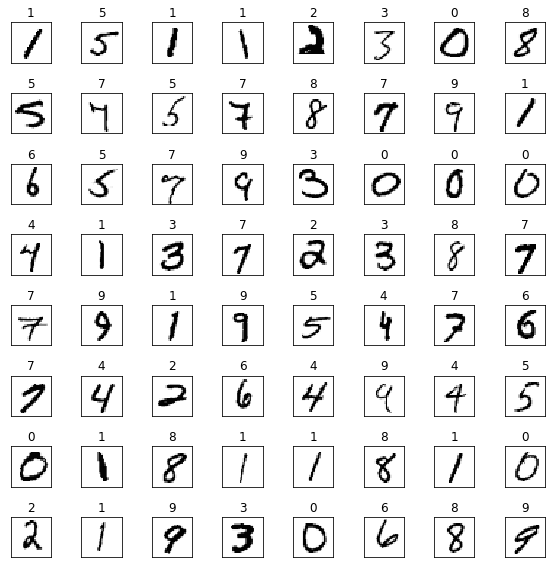

In [6]:
dataiter = iter(trainloader) # Create an iterator from trainloader

images, labels = next(dataiter)

fig = plt.figure(figsize=(8,8))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5
           
    plt.imshow(img, cmap='Greys')
    
    ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Neural Network with `torch.tensor`

[PyTorch](https://pytorch.org/) is a modern an powerful deep learning framework that provides all the building blocks needed to define state-of-the-art deep learning architectures. However, PyTorch magic is based on `torch.tensor` and `torch.autograd`: tensors are used for fast computation (possibly GPU-accelerated) while `torch.autograd` keeps track of such computations and make it easy to compute gradients via backpropagation. Here we will try to implement a simple multi-layer perceptron using only `torch.tensor`.

### Define the Neural Network

In order to define a multi-layer perceptron we need an activation function. Here we use the rectified linear unit (ReLU) activation function defined by
$$
    \text{ReLU}(x) = \begin{cases} 0 \quad x \le 0 \\ x \quad x > 0 \end{cases}
$$

In [7]:
def relu(x):
    z = torch.zeros_like(x)
    
    return torch.max(x, z)

This is equivalent to `nn.ReLU`.

With the activation function we can finally define out model, which in this case is a multi-layer perceptron:

In [8]:
def nnmodel(x, weights, biases):
    for w, b in zip(weights[:-1], biases[:-1]):
        x = torch.matmul(x, w) + b # Linear unit
        x = relu(x) # 
        
    return torch.matmul(x, weights[-1]) + biases[-1]

This is equivalent to `nn.Sequential([nn.Linear, nn.ReLU, nn.Linear, nn.Relu, nn.Linear])`.

The previous model outputs *logits*, [...]. We can transform the output of our model into class probabilities using the *softmax* function:
$$
    \text{softmax}(\mathbf{x}) = \frac{e^\mathbf{x}}{\sum_i e^{x_i}}
$$

In [9]:
def softmax(x):
    # The first dimension is batch_size
    # To sum over classes we have to sum over dim=1
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1, 1)

This is equivalent to `nn.Softmax`.

### Weights and Biases Initialization

Weights and baisese initialization is a delicate business and care should be taken when initializing weights. The general consensus is that the weighs should be initialized from a uniform random distributions on the interval $[-y, y]$ where $1/\sqrt{n}$ for a layer with $n$ inputs:

In [10]:
def uniform(*size):
    n = size[0] # Input size
    
    isn = 1 / np.sqrt(n)
    
    samples = np.random.uniform(-isn, isn, size=size)
    
    return samples

w1 = torch.tensor(uniform(784, 256), requires_grad=True, dtype=torch.float)
b1 = torch.tensor(uniform(256), requires_grad=True, dtype=torch.float)
w2 = torch.tensor(uniform(256, 128), requires_grad=True, dtype=torch.float)
b2 = torch.tensor(uniform(128), requires_grad=True, dtype=torch.float)
w3 = torch.tensor(uniform(128, 10), requires_grad=True, dtype=torch.float)
b3 = torch.tensor(uniform(10), requires_grad=True, dtype=torch.float)

weights = [w1, w2, w3]
biases = [b1, b2, b3]

A normali distribution $\mathcal{N}(0, y)$ would have similar performance. See [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) for more informations.


### Test Forward Pass

In order to check that the model is defined correctly we can perfom a forward pass with a batch of images. We can also see how the model performs before training  by plotting predicting class probabilities.

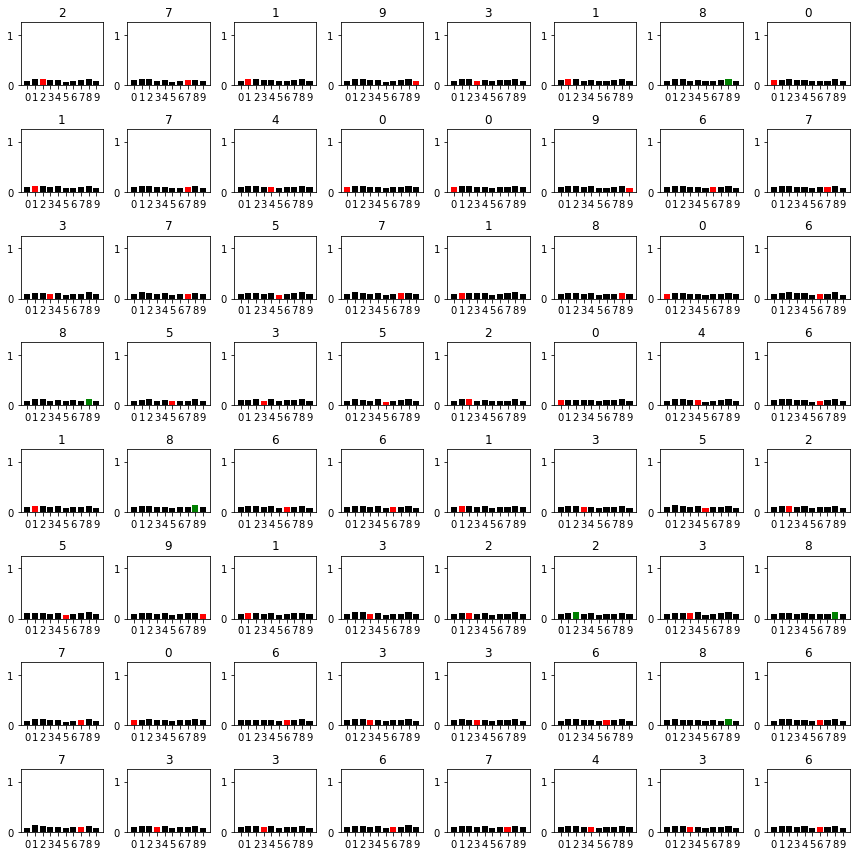

In [11]:
# Get one batch of data
images, labels = next(dataiter)

# Define a wrapper to nnmodel
# This incorporated weights and biases
def model(x):
    return nnmodel(x, weights, biases)

def showclassp(images, labels, model):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    # Defint a figure
    fig = plt.figure(figsize=(12,12))
    
    # Flatten image for forward pass
    images = images.view(images.shape[0], -1)

    # Compute predictions
    with torch.no_grad(): # Do not track gradients
        # Perform forward pass
        out = model(images)
            
        # Compute class probabilities
        p = softmax(out).numpy()
    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        # Plot all class probabilities for given image
        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])

        ax.set_title(labels[idx].item(), fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
showclassp(images, labels, model)

Since the weights of the network are initialised at random, every class has a similar probability close to $\frac{1}{10}$.

### Training

In [12]:
def cross_entropy_loss(p, labels):
    
    n = len(labels)
    
    # One-hot encoding
    l = torch.zeros((n, 10))
    l[range(n),labels] = 1
    
    # Compute cross-entropy loss
    return -torch.sum(l * torch.log(p), dim=1).mean()

This is equivalent to `nn.CrossEntropyLoss`.

Now that everything is in place, we can finally train our model:

In [13]:
lr = 0.03
epochs = 5

for epoch in range(epochs):
    
    epoch_loss = 0
    
    for images, labels in trainloader:
        
        inputs = images.view(images.shape[0], -1)
        
        out = nnmodel(inputs, weights, biases)
        p = softmax(out)
        
        loss = cross_entropy_loss(p, labels)
        loss.backward()
        
        for w, b in zip(weights, biases):
            # Perform gradient descent step
            w.data.sub_(lr * w.grad.data)
            b.data.sub_(lr * b.grad.data)
            
            # Zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
            
        epoch_loss += loss.item()
    else:
        print(f"Loss #{epoch}: {epoch_loss/len(trainloader)}")

Loss #0: 0.5850942751100503
Loss #1: 0.27245648269290096
Loss #2: 0.20717006267755111
Loss #3: 0.16645640936921666
Loss #4: 0.1376965147132012


The training loop above changes the weights and biases of the networs using gradient descent in order to minimize the loss function (`cross_entropy_loss`). We can finally evaluate the performance of the model:

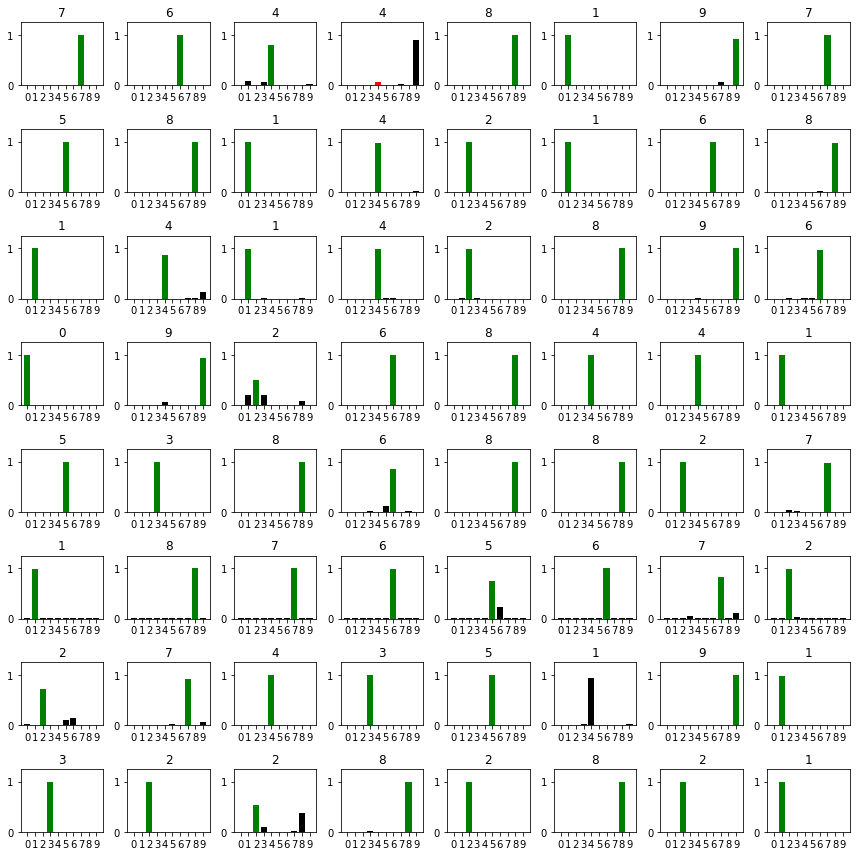

In [14]:
images, labels = next(dataiter)

showclassp(images, labels, model)